import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from matplotlib import gridspec
import pickle as pkl
import itertools
import matplotlib.pyplot as plt
import sys, os
opj = os.path.join
ope = os.path.exists
this_dir = os.getcwd()
lib_paths = [opj(this_dir, 'bestfitting/protein_clean/src'), opj(this_dir, 'CD'), opj(this_dir, 'viz')]
for lib_path in lib_paths:
    if lib_path not in sys.path:
        sys.path.insert(0, lib_path) 

In [2]:
from cd_propagate import *
from cd import *
from dset import *
from score_funcs import *
import viz 
from config.config import * # set directory paths (DATA_DIR, RESULT_DIR etc) 
import train_cls_net # import Protein class
from net.loss_funcs.kaggle_metric import prob_to_result # import prob_to_result
from net.loss_funcs.kaggle_metric import get_probs_f1_score # import get_probs_f1_score  
import warnings
warnings.filterwarnings("ignore")

run on ip-172-31-63-74


### Set parameters and directories

In [3]:
# get args
args = get_args()

# set dirs
# fname=which file to evaluate
dir_args, data_args = set_dirs(args, fname='valid_160.csv')

# get Protein class
trainer = train_cls_net.Protein(dir_args,
                                train_batch_size=args.train_batch_size,
                                test_batch_size=args.test_batch_size,
                                seed=args.seed, img_size=args.img_size,in_channels=args.in_channels,
                                save_probs=args.save_probs,
                                aug_version=args.aug_version,
                                num_classes=args.num_classes,
                                crop_size=args.crop_size,
                                clipnorm=args.clipnorm)

# load model
net, scheduler, loss = load_densenet_pretrained(args, trainer, data_args)

# test dataset and dataloader
test_dataset = get_dataset(trainer)
test_loader = protein_dataset.DataLoader(test_dataset,
                                         sampler=SequentialSampler(test_dataset),
                                         batch_size=trainer.test_batch_size,
                                         drop_last=False,
                                         num_workers=trainer.num_workers,
                                         pin_memory=True)

in_channels 4
load model file from: /home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/result/models/external_crop1024_focal_slov_hardlog_clean_class_densenet121_large_dropout_i1536_aug2_5folds/fold0/final.pth
using gpu 0
/home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/data/train/images_1536
/home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/data/train/external_v18_1536


In [4]:
# use gpu
if trainer.gpu_flag:
    net.cuda()
# net eval mode
net.eval()

print('ready to evaluate')

ready to evaluate


### CD score

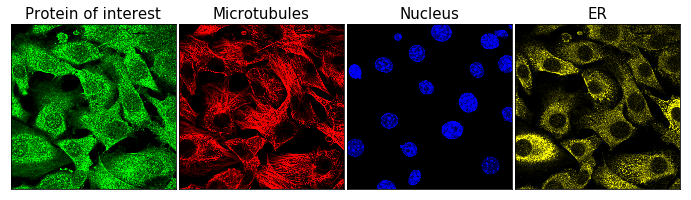

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0]])


In [5]:
from cd_propagate import *
# load test image
load_img = pkl.load(open('./data/test_image', 'rb'))
test_image = load_img['image']
test_label = load_img['label']

# viz test image
img_index = 0
viz.viz_channels_separate(test_image, img_index)
print(test_label)

In [6]:
# test image
im = test_image.clone()

# switch dtype
dtype = torch.double
im = torch.tensor(im, dtype=dtype)
net.float() if dtype==torch.float else net.double()
print('switch to', dtype)

# relevant scores
img_resize = 1024
superpixel_size = 32 # superpixel size
h_num, w_num = int(img_resize/superpixel_size), int(img_resize/superpixel_size)

rel_scores = torch.zeros(len(test_image), img_resize, img_resize, NUM_CLASSES, dtype=dtype)

switch to torch.float64


In [7]:
# get modules for network
mods = forward_mods(net)
mods.insert(0, norm) # add normalization in the beginning

# set up blobs
blob = torch.zeros(test_image.size(), dtype=dtype)
blob[:,:,0*superpixel_size:(0+1)*superpixel_size,0*superpixel_size:(0+1)*superpixel_size] = 1
blob = blob.to(device)

# decompose
relevant = blob * im.to(device)
irrelevant = (1 - blob) * im.to(device)

# normalization
relevant, irrelevant = blob * mods[0](relevant + irrelevant), (1 - blob) * mods[0](relevant + irrelevant)
output = mods[0](im.to(device))
print('layer0:', torch.norm(relevant + irrelevant - output).item())

# propagate layers
with torch.no_grad():
    # growth rate = 4; block config = (6, 12, 24, 16)
    # initial convolution
    relevant, irrelevant = propagate_conv(relevant, irrelevant, mods[1][0])
    output = mods[1][0](output)
    print('layer1-0:', torch.norm(relevant + irrelevant - output).item())
    
    relevant, irrelevant = propagate_batchnorm2d(relevant, irrelevant, mods[1][1])
    output = mods[1][1](output)
    print('layer1-1:', torch.norm(relevant + irrelevant - output).item())    
    
    relevant, irrelevant = propagate_relu(relevant, irrelevant, mods[1][2])
    output = mods[1][2](output)
    print('layer1-2:', torch.norm(relevant + irrelevant - output).item())   
    
    relevant, irrelevant = propagate_pooling(relevant, irrelevant, mods[1][3])
    output = mods[1][3](output)
    print('layer1-3:', torch.norm(relevant + irrelevant - output).item())      
    
    relevant, irrelevant = propagate_pooling(relevant, irrelevant, mods[2])
    output = mods[2](output)
    print('layer2:', torch.norm(relevant + irrelevant - output).item())  
    
    relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[3])
    output = mods[3](output)
    print('layer3:', torch.norm(relevant + irrelevant - output).item())    
    
    # transition1
    relevant, irrelevant = propagate_transition(relevant, irrelevant, mods[4])
    output = mods[4](output)
    print('layer4:', torch.norm(relevant + irrelevant - output).item())    

    # denseblock2
    relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[5])
    output = mods[5](output)
    print('layer5:', torch.norm(relevant + irrelevant - output).item())    

    # transition2
    relevant, irrelevant = propagate_transition(relevant, irrelevant, mods[6])
    output = mods[6](output)
    print('layer6:', torch.norm(relevant + irrelevant - output).item())    

    # denseblock3
    relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[7])
    output = mods[7](output)
    print('layer7:', torch.norm(relevant + irrelevant - output).item())    

    # transition3
    relevant, irrelevant = propagate_transition(relevant, irrelevant, mods[8])
    output = mods[8](output)
    print('layer8:', torch.norm(relevant + irrelevant - output).item())    

    # denseblock4
    relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[9])
    output = mods[9](output)
    print('layer9:', torch.norm(relevant + irrelevant - output).item())    

    # final batch norm
    relevant, irrelevant = propagate_batchnorm2d(relevant, irrelevant, mods[10])
    output = mods[10](output)
    print('layer10:', torch.norm(relevant + irrelevant - output).item())    

    # ReLU layer
    relevant, irrelevant = propagate_relu(relevant, irrelevant, mods[11])
    output = mods[11](output)
    print('layer11:', torch.norm(relevant + irrelevant - output).item())    
    
    # adaptive avgpooling and maxpooling
    rel0, irrel0 = propagate_avgpooling(relevant, irrelevant, mods[12])
    rel1, irrel1 = propagate_pooling(relevant, irrelevant, mods[13])
    relevant, irrelevant = torch.cat((rel0, rel1), dim=1), torch.cat((irrel0, irrel1), dim=1)
    output0 = mods[12](output)
    output1 = mods[13](output)
    output = torch.cat((output0, output1), dim=1)
    print('layer12&13:', torch.norm(relevant + irrelevant - output).item())    

    # reshape
    relevant = relevant.view(relevant.size(0), -1)
    irrelevant = irrelevant.view(irrelevant.size(0), -1)
    output = output.view(output.size(0), -1)
    print('layer14:', torch.norm(relevant + irrelevant - output).item())    
    
    # bn1 layer
    relevant, irrelevant = propagate_batchnorm1d(relevant, irrelevant, mods[14])
    output = mods[14](output)
    print('layer14:', torch.norm(relevant + irrelevant - output).item())    

layer0: 0.0
layer1-0: 1.2211049277151246e-13
layer1-1: 3.667197527763215e-12
layer1-2: 3.483125685292263e-12
layer1-3: 2.4165437624183743e-12
layer2: 1.3885788168810646e-12
layer3: 1.2457705171465327e-11
layer4: 4.220855063659192e-12
layer5: 1.0574089082137001e-11
layer6: 2.8007521289971098e-12
layer7: 7.485267134077388e-12
layer8: 2.294413724885945e-12
layer9: 3.0912600534711575e-12
layer10: 1.7854934730048428e-11
layer11: 1.3593680065129153e-11
layer12&13: 1.6071901184733628e-12
layer14: 1.6071901184733628e-12
layer14: nan


In [8]:
relevant

tensor([[        nan,  1.5551e-03, -1.2539e-02,  ..., -3.1853e-05,
         -5.4221e-05, -5.4012e-05]], device='cuda:0', dtype=torch.float64)

In [ ]:
relevant.shape

In [ ]:
mods[14].weight.shape

In [ ]:
mod = mods[14]
bias = mod(torch.zeros(irrelevant.size(), dtype=dtype).to(device))
rel = mod(relevant) - bias
irrel = mod(irrelevant) - bias

# elementwise proportional
# prop_rel = torch.abs(rel).sum(axis=(0,2,3))
# prop_irrel = torch.abs(irrel).sum(axis=(0,2,3))
# prop_sum = prop_rel + prop_irrel
# prop_rel = torch.div(prop_rel, prop_sum)
# prop_irrel = torch.div(prop_irrel, prop_sum)

In [ ]:
irrel.shape

In [ ]:
torch.mul(prop_rel.view(1,-1,1,1), bias)

In [ ]:
prop_rel.view(1,-1,1,1).shape

In [ ]:
prop_rel.unsqueeze(0).shape

In [ ]:
bias = mods[1][1](torch.zeros(irrelevant.size(), dtype=dtype).to(device))
rel = mods[1][1](relevant) - bias
irrel = mods[1][1](irrelevant) - bias

# elementwise proportional
prop_rel = torch.abs(rel).sum(axis=(0,2,3))
prop_irrel = torch.abs(irrel).sum(axis=(0,2,3))

In [ ]:
rel[:,0,:,:].shape

In [ ]:
prop_rel

In [ ]:
prop_irrel

In [ ]:
prop_rel

In [ ]:
prop_rel.sum(axis=(0,2,3))

In [ ]:
mod = mods[3][0][0]

In [ ]:
mod.weight

In [ ]:
rel.shape

In [ ]:
    dtype = relevant.dtype
    bias = module(torch.zeros(irrelevant.size(), dtype=dtype).to(device))
    rel = module(relevant) - bias
    irrel = module(irrelevant) - bias

    # elementwise proportional
    prop_rel = torch.abs(rel)
    prop_irrel = torch.abs(irrel)
    prop_sum = prop_rel + prop_irrel
    prop_rel = torch.div(prop_rel, prop_sum)
    prop_irrel = torch.div(prop_irrel, prop_sum)
    # nan_ind = torch.isnan(prop_rel)
    # prop_rel[nan_ind] = .9
    # prop_irrel[nan_ind] = .1
    return rel + torch.mul(prop_rel, bias), irrel + torch.mul(prop_irrel, bias)
    # return rel + 0.1*bias, irrel + 0.9*bias
    # prop_rel[torch.isnan(prop_rel)] = .0
    # rel = rel + torch.mul(prop_rel, bias)
    # irrel = module(relevant + irrelevant) - rel
    # return rel, irrel

In [ ]:
def cd_densenet(blob, im_torch, model):
    '''CD Densenet
    '''
    # set up model
    model.eval()

    # get modules for network
    mods = forward_mods(model)
    mods.insert(0, norm) # add normalization in the beginning

    # set up blobs
    device = torch.device("cuda")
    blob = blob.to(device)

    scores = []
    # output = im_torch.clone().detach().double().to(device)
    output = im_torch.clone().detach().to(device)
    # decompose
    relevant = blob * output
    irrelevant = (1 - blob) * output

    # normalization
    relevant, irrelevant = blob * mods[0](relevant + irrelevant), (1 - blob) * mods[0](relevant + irrelevant)
    scores.append((relevant.clone(), irrelevant.clone()))

    # propagate layers
    with torch.no_grad():
        # growth rate = 4; block config = (6, 12, 24, 16)
        # initial convolution
        relevant, irrelevant = propagate_init_conv(relevant, irrelevant, mods[1])
        scores.append((relevant.clone(), irrelevant.clone()))

        if model.module.large:
            relevant, irrelevant = propagate_pooling(relevant, irrelevant, mods[2])
            scores.append((relevant.clone(), irrelevant.clone()))

        # denseblock1
        relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[3])
        scores.append((relevant.clone(), irrelevant.clone()))

        # transition1
        relevant, irrelevant = propagate_transition(relevant, irrelevant, mods[4])
        scores.append((relevant.clone(), irrelevant.clone()))

        # denseblock2
        relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[5])
        scores.append((relevant.clone(), irrelevant.clone()))

        # transition2
        relevant, irrelevant = propagate_transition(relevant, irrelevant, mods[6])
        scores.append((relevant.clone(), irrelevant.clone()))

        # denseblock3
        relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[7])
        scores.append((relevant.clone(), irrelevant.clone()))

        # transition3
        relevant, irrelevant = propagate_transition(relevant, irrelevant, mods[8])
        scores.append((relevant.clone(), irrelevant.clone()))

        # denseblock4
        relevant, irrelevant = propagate_denseblock(relevant, irrelevant, mods[9])
        scores.append((relevant.clone(), irrelevant.clone()))

        # final batch norm
        relevant, irrelevant = propagate_batchnorm2d(relevant, irrelevant, mods[10])
        scores.append((relevant.clone(), irrelevant.clone()))

        # ReLU layer
        relevant, irrelevant = propagate_relu(relevant, irrelevant, mods[11])
        scores.append((relevant.clone(), irrelevant.clone()))

        if model.module.dropout:
            # adaptive avgpooling and maxpooling
            rel0, irrel0 = propagate_avgpooling(relevant, irrelevant, mods[12])
            rel1, irrel1 = propagate_pooling(relevant, irrelevant, mods[13])
            relevant, irrelevant = torch.cat((rel0, rel1), dim=1), torch.cat((irrel0, irrel1), dim=1)
            scores.append((relevant.clone(), irrelevant.clone()))

            # reshape
            relevant = relevant.view(relevant.size(0), -1)
            irrelevant = irrelevant.view(irrelevant.size(0), -1)
            scores.append((relevant.clone(), irrelevant.clone()))

            # bn1 layer
            relevant, irrelevant = propagate_batchnorm1d(relevant, irrelevant, mods[14])
            scores.append((relevant.clone(), irrelevant.clone()))

            # fn1 layer
            relevant, irrelevant = propagate_linear(relevant, irrelevant, mods[15])
            scores.append((relevant.clone(), irrelevant.clone()))

            # ReLU layer
            relevant, irrelevant = propagate_relu(relevant, irrelevant, mods[16])
            scores.append((relevant.clone(), irrelevant.clone()))

            # bn2 layer
            relevant, irrelevant = propagate_batchnorm1d(relevant, irrelevant, mods[17])
            scores.append((relevant.clone(), irrelevant.clone()))

        # reshape
        relevant = relevant.view(relevant.size(0), -1)
        irrelevant = irrelevant.view(irrelevant.size(0), -1)

        # linear layer
        relevant, irrelevant = propagate_linear(relevant, irrelevant, mods[18])
        scores.append((relevant.clone(), irrelevant.clone()))

    return relevant.cpu(), irrelevant.cpu(), scores

In [ ]:
accuracy = []

with torch.no_grad():
    for h, w in itertools.product(range(h_num), range(w_num)):
        # set up blobs
        blob = torch.zeros(test_image.size(), dtype=dtype)
        blob[:,:,h*superpixel_size:(h+1)*superpixel_size,w*superpixel_size:(w+1)*superpixel_size] = 1

        relevant, irrelevant, _ = cd_densenet(blob, im, net)
        output, _ = forward_pass(im, net)
        
        accuracy.append(torch.norm(relevant + irrelevant - output))
        if accuracy[-1] > 1e-3:
            print('sum of cd scores do not match the original ouput at (height,width) =', (h,w))
        if torch.isnan(accuracy[-1]).sum().item() >= 1:
            print('Nan occured')

        rel_scores[:,h*superpixel_size:(h+1)*superpixel_size, 
                        w*superpixel_size:(w+1)*superpixel_size,:] = relevant

        print('\r iterations (height,width) =', (h,w), end='')

In [ ]:
viz.viz_channels_combined(test_image, img_index, rel_scores[0,:,:,2])